## Import Dependencies

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
import random
import seaborn as sns

In [4]:
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose
from keras.applications.vgg16 import VGG16

## Initialize Variables

After importing the libraries, we initialize all the necessary variables - 
* `train_folder` - Path for training images
* `valid_folder` - Path for testing images
* `width` - Width of an image
* `height` - Height of an image
* `classes` - No. of discrete pixel values in the segmentation maps (no. of labels)
* `batch_size` - Size of a single batch
* `num_of_training_samples` - Total number of training samples
* `num_of_testing_samples` - Total number of testing samples

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# !unzip -uq "/content/drive/My Drive/cityscapes_data.zip" -d "/content/drive/My Drive/data"

In [7]:
import os
os.getcwd()
%cd /content/drive/My\ Drive/
os.getcwd()

/content/drive/My Drive


'/content/drive/My Drive'

In [8]:
train_folder="./data/cityscapes_data/train/"
valid_folder="./data/cityscapes_data/val/"
width = 256
height = 256
classes = 30
batch_size = 10
num_of_training_samples = len(os.listdir(train_folder)) 
num_of_testing_samples = len(os.listdir(valid_folder))

## Helper Functions

## Load Image and Segmentation Mask

In [9]:
def LoadImage(name, path):
    img = Image.open(os.path.join(path, name))
    img = np.array(img)
    
    image = img[:,:256]
    mask = img[:,256:]
    
    return image, mask

## Bin Segmentation Mask 

In [10]:
def bin_image(mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(mask, bins)
    return new_mask

## Segmentation Masks to Categorical Arrays 

In [11]:
def getSegmentationArr(image, classes, width=width, height=height):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, : , 0]

    for c in range(classes):
        seg_labels[:, :, c] = (img == c ).astype(int)
    return seg_labels

## Categorical Arrays to Colored Segmentation Masks

In [12]:
def give_color_to_seg_img(seg, n_classes=30):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

## Generator function to generate data batches

In [13]:
def DataGenerator(path, batch_size=10, classes=30):
    files = os.listdir(path)
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i : i+batch_size]
            imgs=[]
            segs=[]
            for file in batch_files:
                #file = random.sample(files,1)[0]
                image, mask = LoadImage(file, path)
                mask_binned = bin_image(mask)
                labels = getSegmentationArr(mask_binned, classes)

                imgs.append(image)
                segs.append(labels)

            yield np.array(imgs), np.array(segs)

## Visualize Data Samples

In [14]:
train_gen = DataGenerator(train_folder, batch_size=batch_size)
val_gen = DataGenerator(valid_folder, batch_size=batch_size)

In [15]:
imgs, segs = next(train_gen)
imgs.shape, segs.shape

((10, 256, 256, 3), (10, 256, 256, 30))

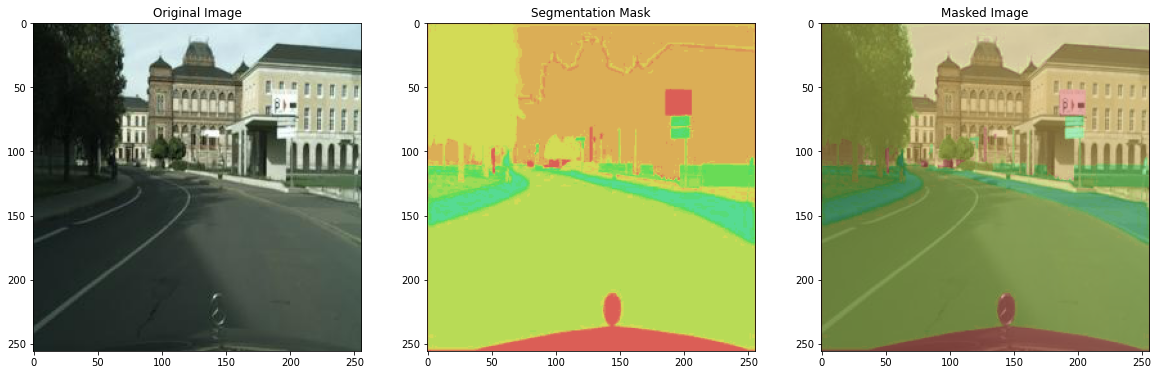

In [16]:
image = imgs[0]
mask = give_color_to_seg_img(np.argmax(segs[0], axis=-1))
masked_image = cv2.addWeighted(image/255, 0.5, mask, 0.5, 0)

fig, axs = plot.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')
#predimg = cv2.addWeighted(imgs[i]/255, 0.6, _p, 0.4, 0)
axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plot.show()

## Segmentation model - U-net++

In [17]:
from tensorflow.keras.layers import MaxPooling2D, Dropout, Conv2DTranspose, Conv2D, concatenate
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.backend import binary_crossentropy, square
from tensorflow.keras.backend import sum as ksum
from tensorflow.keras import Model, Input
import tensorflow as tf


def conv2d_block(input_tensor, n_filters=16, filter_size=3, activation='relu', pad='same', batch_norm=True):
    """
    Custom block method to perform consecutive convolutions with optional batch normalization

    Inputs
    --
    input_tensor: tensor
        Input image tensor data structure defined within Keras
    n_filters: int
        Depth for the convolution layer outputs
    filter_size: int
        Dimensions of the filter convolved with the tensor inputs
    activation: string
        Activation function for the intermediate layers between convolutions
    pad: string
        Determination of if input shape is maintained in convolution
    batch_norm: bool
        Flag if batch normalization is used

    Outputs
    --
    x: tensor
        Twice convolved input with optional batch normalization and activation non-linearities
    """
    
    x = Conv2D(filters=n_filters, kernel_size=(filter_size, filter_size),
               kernel_initializer='he_normal', padding=pad)(input_tensor)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv2D(filters=n_filters, kernel_size=(filter_size, filter_size),
               kernel_initializer='he_normal', padding=pad)(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x


def UNET_plusplus(input_shape=(256,256,3), conv_block=conv2d_block, n_filters=32, dropout=0.5, padding='same', batch_norm=True):
    """
    UNET++ architecture as originally outlined in https://arxiv.org/pdf/1807.10165.pdf with modifications 
    to fit different input dimensions. 

    Inputs
    --
    input_shape: tuple(int)
        Tuple in 3D corresponding to the dimensions of the input images
    conv_block: func
        Custom block method to perform consecutive convolutions with optional batch normalization
    n_filters: int
        Number of filters corresponding to depth of input for next layer
    dropout: float
        Dropout percentage hyperparameter to tune overfitting
    padding: string
        Descriptor determining if padding maintain size during convolutions
    batch_norm: bool
        Determines if batch normalization is used

    Outputs
    --
    model: Model
        Returns model architecture without compile
    """

    tensor = Input(shape=input_shape)

    print('Backbone')
    
    c00 = conv_block(tensor, n_filters * 1, filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p00 = MaxPooling2D((2, 2))(c00)
    p00 = Dropout(dropout)(p00)
    
    c10 = conv_block(p00, n_filters * 2, filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p10 = MaxPooling2D((2, 2))(c10)
    p10 = Dropout(dropout)(p10)

    c20 = conv_block(p10, n_filters * 4,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p20 = MaxPooling2D((2, 2))(c20)
    p20 = Dropout(dropout)(p20)

    c30 = conv_block(p20, n_filters * 8,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p30 = MaxPooling2D((2, 2))(c30)
    p30 = Dropout(dropout)(p30)

    c40 = conv_block(p30, n_filters * 16, filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    
    print('First Up Path')
    
    u01 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding=padding)(c10)
    u01 = concatenate([u01, c00])
    u01 = Dropout(dropout)(u01)
    c01 = conv_block(u01, n_filters * 1,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    
    print('Second Up Path')

    u11 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding=padding)(c20)
    u11 = concatenate([u11, c10])
    u11 = Dropout(dropout)(u11)
    c11 = conv_block(u11, n_filters * 2,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    u02 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding=padding)(c11)
    u02 = concatenate([u02, c01, c00])
    u02 = Dropout(dropout)(u02)
    c02 = conv_block(u02, n_filters * 1,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm) 
    
    print('Third Up Path')

    u21 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding=padding)(c30)
    u21 = concatenate([u21, c20])
    u21 = Dropout(dropout)(u21)
    c21 = conv_block(u21, n_filters * 4,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)   

    u12 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding=padding)(c21)
    u12 = concatenate([u12, c11, c10])
    u12 = Dropout(dropout)(u12)
    c12 = conv_block(u12, n_filters * 2,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    u03 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding=padding)(c12)
    u03 = concatenate([u03, c02, c01, c00])
    u03 = Dropout(dropout)(u03)
    c03 = conv_block(u03, n_filters * 1,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)    

    print('Final Up Path')

    u31 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding=padding)(c40)
    u31 = concatenate([u31, c30])
    u31 = Dropout(dropout)(u31)
    c31 = conv_block(u31, n_filters * 8,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm) 

    u22 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding=padding)(c31)
    u22 = concatenate([u22, c21, c20])
    u22 = Dropout(dropout)(u22)
    c22 = conv_block(u22, n_filters * 4,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    u13 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding=padding)(c22)
    u13 = concatenate([u13, c12, c11, c10])
    u13 = Dropout(dropout)(u13)
    c13 = conv_block(u13, n_filters * 2,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    u04 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding=padding)(c13)
    u04 = concatenate([u04, c03, c02, c01, c00])
    u04 = Dropout(dropout)(u04)
    c04 = conv_block(u04, n_filters * 1,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)  

    #Outputs
    outputs = Conv2D(30, (1, 1), activation='softmax')(c04)
    model = Model(inputs=[tensor], outputs=[outputs])

    # Return model architecture
    return model

In [18]:
# Initialize UNET
model = UNET_plusplus(input_shape=(256,256,3), conv_block=conv2d_block, n_filters=8, dropout=0.5, padding='same', batch_norm=True)
print(model.summary())

Backbone
First Up Path
Second Up Path
Third Up Path
Final Up Path
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 8)  0           batch_normalization[0][0]        
____________________________

## Train our model

In [19]:
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [20]:
history = model.fit(train_gen, epochs=10, steps_per_epoch=num_of_training_samples//batch_size,\
                       validation_data=val_gen, validation_steps=num_of_testing_samples//batch_size)

Epoch 1/10
297/297 [==============================] - 1631s 5s/step - loss: 1.2652 - accuracy: 0.6516 - val_loss: 1.5276 - val_accuracy: 0.6639
Epoch 2/10
297/297 [==============================] - 116s 391ms/step - loss: 1.0097 - accuracy: 0.7137 - val_loss: 1.1628 - val_accuracy: 0.6786
Epoch 3/10
297/297 [==============================] - 117s 394ms/step - loss: 0.9539 - accuracy: 0.7313 - val_loss: 1.0614 - val_accuracy: 0.7058
Epoch 4/10
297/297 [==============================] - 116s 391ms/step - loss: 0.9217 - accuracy: 0.7399 - val_loss: 1.0241 - val_accuracy: 0.7126
Epoch 5/10
297/297 [==============================] - 116s 391ms/step - loss: 0.8968 - accuracy: 0.7470 - val_loss: 0.9513 - val_accuracy: 0.7309
Epoch 6/10
297/297 [==============================] - 115s 387ms/step - loss: 0.8761 - accuracy: 0.7524 - val_loss: 0.8900 - val_accuracy: 0.7473
Epoch 7/10
297/297 [==============================] - 116s 391ms/step - loss: 0.8560 - accuracy: 0.7574 - val_loss: 0.8890 - v

In [21]:
# Save the weights
model.save_weights('./checkpoints/UNET++')

141008
196608


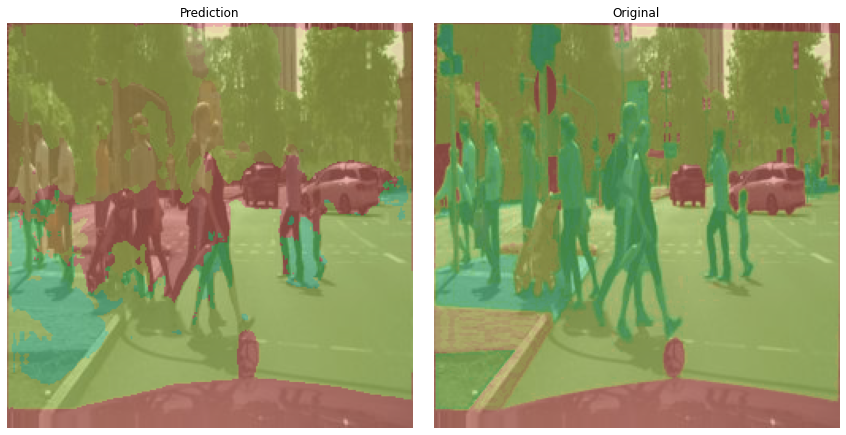

166382
196608


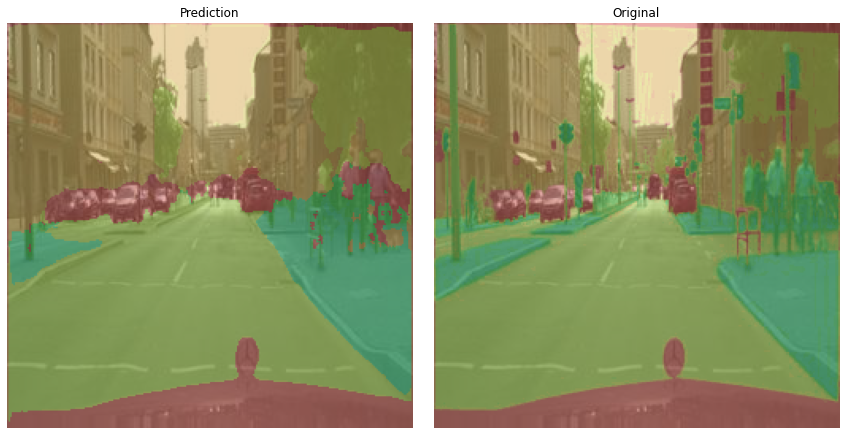

174386
196608


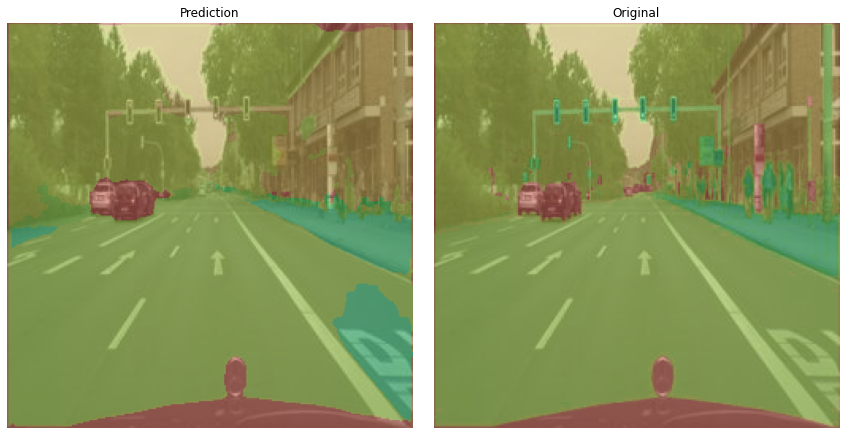

179649
196608


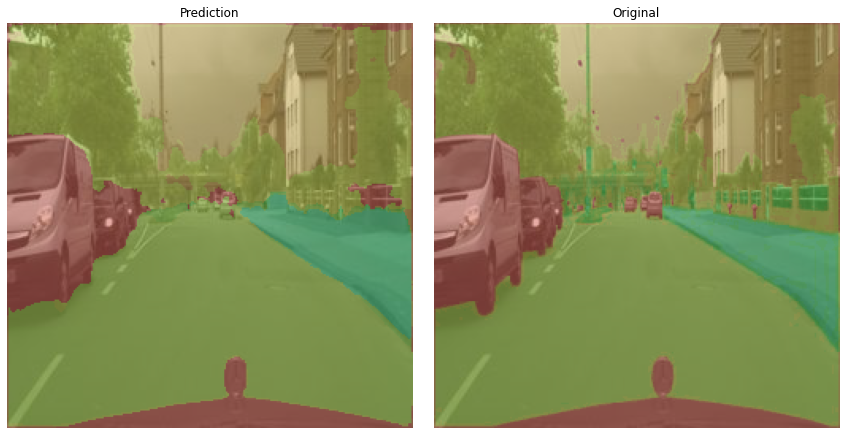

168788
196608


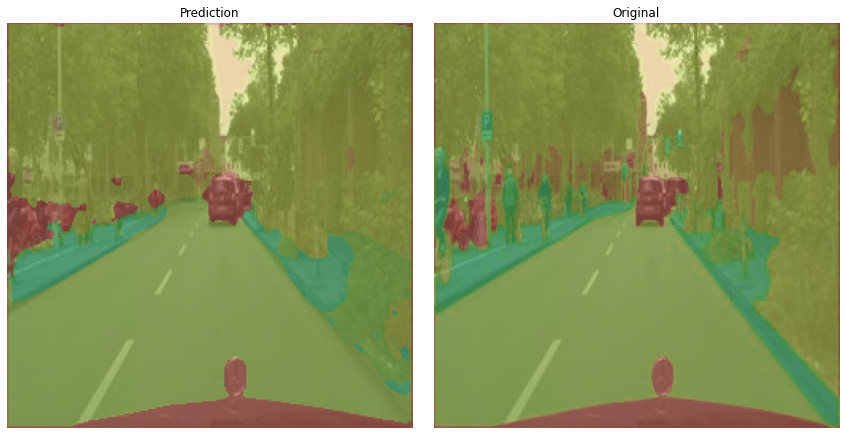

In [29]:
#model_1 output visualization
imgs, segs = next(val_gen)
pred = model.predict(imgs)

ni = 5
# scores = []
for i in range(ni):
    _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
    _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

    predimg = cv2.addWeighted(imgs[i]/255, 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[i]/255, 0.5, _s, 0.5, 0)
    intersection = (np.sum(predimg==trueimg))
    union = (np.shape(predimg)[0]*np.shape(predimg)[1]*np.shape(predimg)[2])
    print(intersection)
    print(union)
    scores.append(intersection/union)
    
    plot.figure(figsize=(12,6))
    plot.subplot(121)
    plot.title("Prediction")
    plot.imshow(predimg)
    plot.axis("off")
    plot.subplot(122)
    plot.title("Original")
    plot.imshow(trueimg)
    plot.axis("off")
    plot.tight_layout()
    plot.savefig("pred_"+str(i)+".png", dpi=150)
    plot.show()

In [30]:
#average Pixel accuracy score
imgs, segs = next(val_gen)
pred = model.predict(imgs)

print(scores)
print(np.sum(scores)/len(scores))

[0.9015858968098959, 0.8799591064453125, 0.8220418294270834, 0.8303578694661459, 0.8876241048177084, 0.6553904215494791, 0.8492431640625, 0.7755533854166666, 0.7682342529296875, 0.677337646484375, 0.8585205078125, 0.8679300944010416, 0.6523946126302084, 0.8788553873697916, 0.8561350504557291, 0.8459370930989584, 0.8986562093098959, 0.8663431803385416, 0.9262237548828125, 0.8576405843098959, 0.8755544026692709, 0.8067372639973959, 0.8081003824869791, 0.7870076497395834, 0.8885345458984375, 0.7172037760416666, 0.8462626139322916, 0.8869730631510416, 0.9137420654296875, 0.8585001627604166]
0.8314860026041668


In [43]:
#mIoU
intersection = np.sum(np.abs(segs*pred))
union = np.sum(segs)+np.sum(pred)-intersection
iou = np.mean((intersection + 1) / (union + 1))
print(iou)

0.5616076562576738
